Work done by Janice Lee 20009280

I am using convolutional neural network to recognise patterns within images of the 4 classes (bicycles, cars, deer, mountains). 

For references I have used includes:
- https://keras.io/api/data_loading/image/
- https://keras.io/api/layers/preprocessing_layers/
- https://keras.io/guides/sequential_model/
- https://medium.com/nerd-for-tech/ways-to-build-keras-models-198f6a643944 for analysis

In [23]:
# Tensorflow (keras) to perform all my machine learning tasks 
# Matplotlib to plot my results for a better understanding about the accuracy/loss
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [10]:
# IMAGE PREPROCESSING

# Remove all corrupted images in images folder
# Initialise a counter to track the number of deleted images
num_skipped = 0
# Navigate through all directories/files in './images/'
for root, dirs, files in os.walk("./images/"):
    # Iterate through each file in the current directory
    for file in files:
        # Split the filename into the name and extension
        _, extension = os.path.splitext(file)
        # Check if the file extension is '.jpg'
        if extension == ".jpg":
            filepath = os.path.join(root, file)
            try:
                # Open the image file in binary read mode
                fobj = open(filepath, "rb")
                # Check if the first 10 bytes contain 'JFIF' (JPEG File Interchange Format)
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()
                # Ensure the file is closed after checking

            if not is_jfif:
                # If the file does not conform to JPEG standards (not 'JFIF')
                # Increment the deleted images counter
                num_skipped += 1
                # Delete the corrupted or non-JPEG image file
                os.remove(filepath)

# Print the total number of images deleted
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [11]:
# DATA AUGMENTATION 

data_augmentation = keras.Sequential([
    # Apply random horizontal flip to the images
    layers.RandomFlip("horizontal"),
    # Randomly rotate the images by 0 to 10% of 360 degrees
    layers.RandomRotation(0.1),
    # Randomly change the height of the images by up to ±10%
    layers.RandomHeight(0.1),
    # Randomly change the width of the images by up to ±10%
    layers.RandomWidth(0.1),
])

Data Augmentation is implementated to the images in the images folder:
This method increases the diversity of a training dataset by applying transformations like rotation, flipping, and scaling to the images in 'images' folder. It reduces overfitting and improving overall performance, especially in situations where obtaining more training data is difficult.

In [12]:
# CREATING A DATASET

images_path = "./images/"
# Creating a dataset for training from the images in the specified directory
training_dataset = keras.preprocessing.image_dataset_from_directory(
    images_path,
    # Labels retrieved from the directory structure
    labels='inferred',
    # 1. Choosing categorical because there is a multi-class labels: I have a dataset that holds 4 classes (bicycles, cars, deer and mountains), each label is representated as a one-hot encoded vector
    # 2. Choosing categorical because categorical labeling clearly differentiates between classes, which are unlike binary labels, which can only represent 2 classes and categorical labels represent multiple distint classes
    label_mode='categorical',
    # Images have colour in them, so red green blue channels
    color_mode="rgb",
    # Set batch size to 24, to main consistency, as it provided the best balance of performance and accuracy
    batch_size=24,
    # 1. Set each image size to (150, 150) pixel size as the dataset has a range of formats 
    # 2. Set each image size to (150, 150) so all images are at the same size consistently 
    image_size=(150, 150),
    # Allocate 90% of the data for training, based on the validation split
    subset="training",
    # Remaining 10% of the dataset checks how well the model is performing in terms of the accuracy value 
    # The validation accuracy is to show how well the model is capable when learning new data
    validation_split=0.1,
    # Shuffle the dataset to prevent the model from overfitting and recognising learning order-specific patterns 
    shuffle=True,
    # Set a seed for reproducibility in shuffling and splitting the dataset
    seed=1
)

# Create a dataset for validation from the same directory
test_dataset = keras.preprocessing.image_dataset_from_directory(
    images_path,
    labels='inferred',
    label_mode='categorical',
    color_mode="rgb",
    batch_size=24,
    image_size=(150, 150),
    subset="validation",
    validation_split=0.1,
    shuffle=True,
    seed=1
)

Found 776 files belonging to 4 classes.
Using 699 files for training.
Found 776 files belonging to 4 classes.
Using 77 files for validation.


There are four folders in our 'images' folder, and this process loads images and utilises the directory structure to define the classes, while also dividing the data into separate training and validation datasets

In [13]:
# Applying data augmentation to the training dataset
augmented_train_dataset = training_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
# DATA NORMALISATION

# Define the normalisation layer and applying it to the dataset
# 1. Normalisation process is necessary from scaling pixel values: Images contain pixels which ranges from 0 to 255, the normalisation layer rescales this to 0 and 1 by deviding each pixel by 255
# 2. Normalisation process is necessary to improve the model training, by keeping it 0 and 1 it helps speed up the training process, neural networks converge faster when input data is normalised
# 3. Normalisation process is necessary to minimise internal convariate shift, this is the change in the distribution of network activations because of updates in network parameters
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# Apply the normalisation layer to each image in the augmented training dataset
normalized_train_dataset = augmented_train_dataset.map(lambda x, y: (normalization_layer(x), y))
# Apply the normalisation layer to each image in the test dataset
normalized_test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [33]:
# MODEL BUILDING

# Utilising a sequential model structure as it straightforwardly allows each layer to have a single input and output tensor 
# This means each layer has exactly one input tensor and one output tensor.
model = Sequential([
    # Input Layer: Accepts images of size 150x150 pixels with 3 color channels (RGB)
    # This means not only specifies the size (height, width, color channels) of input images but also initialises the model's initial weights
    layers.Input(shape=(150, 150, 3)),

    # This convolutional layer begins the process of feature extraction.
    # The first convolutional layer applies 32 filters, each of size 3x3, with ReLU activation. 
    # Analysing small portions of the image, identifying features like colours and the edges 
    # The kernel matrix computes the dot product with the input pixels and creates an output matrix representing these features.
    # This is the foundation for recognising more complex patterns and shapes in subsequent layers.
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),

    # Followed by a max pooling layer with a 2x2 pool size and a stride of 2 
    # This reduces the spatial dimensions (height and width) of the output from the previous layer, helping to reduce computation and control overfitting
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # A second convolutional layer with 64 filters, each of size 3x3, and ReLU activation. 
    # This layer captures more complex features
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),

    # Another max pooling layer, further reducing the spatial dimensions of the feature maps
    layers.MaxPooling2D(pool_size=(2, 2)),

    # A third convolutional layer with 128 filters for even more complex feature extraction
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),

    # A final max pooling layer to reduce spatial dimensions.
    layers.MaxPooling2D(pool_size=(2, 2)),

    # A global average pooling layer, which averages the spatial dimensions, reducing each feature map to a single number and flattening the output
    layers.GlobalAveragePooling2D(),

    # A dense layer with 128 units and ReLU activation to interpret the learned features extracted by the convolutional and pooling layers
    layers.Dense(128, activation="relu"),

    # Dropout Layer: Randomly sets a fraction (50% here) of input units to 0 at each update during training.
    # It is a technique to prevent overfitting, especially useful in smaller datasets
    layers.Dropout(0.5),

    # The final output layer with 4 units (one for each class) and a softmax activation function 
    # It outputs a probability distribution over the 4 classes for each input image
    layers.Dense(4, activation="softmax")
])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 128)      

The model initiates with an input layer designed to process images of 150x150 pixels in RGB format, ensuring a standardised input size and color depth for all images for a consistent analysis in convolutional neural network. This model is made of hidden layers collaboratively working to classify the patterns present in images for the four classes (bicycles, cars, deer and mountains). It demonstrates the effectiveness of convolutional neural networks in analysing and identifying contents within images for the purpose of classification.

The model has multiple convolutional layers. Each layer has a 3x3 filter — a small matrix that convolves for the image. As it moves over the image, this filter will perform dot products between its values and the pixel values of the image, to encode the different features of the images. The first convolutional layer, with 32 filters, starts by extracting basic patterns like the edges. The next layers, with a higher number of filters (64 and then 128), to figure out more complex features. This hierarchical feature extraction of having hidden layers helps convolutional neural network to dive deeper, analyse and understand more of the different kind of images and distinguish between them. Following each convolutional layer, a max pooling layer is applied. These layers reduce the spatial dimensionality of the data, making sure that the model remains efficient. By extracting only the most main features within a region (done by pooling), they also contribute to the model's ability reduce overfitting and to generalise. The model has a global average pooling layer as a bridge to the dense layers - this means the model uses a layer that summarises the information from the previous layers before it moves on to the next step of processing. It helps making decisions based on the overall trends on the image than individual details. The dense part of the network has a layer with 128 neurons, this is to see if it is capable to interpret the complex patterns by the convolutional layers. This is followed by a dropout layer, which then randomly deactivates 50% of the neurons in this case during training. Mainly to prevent overfitting, especially when working with limited data. Finally, the network holds a dense layer of 4 neurons, each corresponding to one of the classes in the classification task. A softmax activation function is chosen here, transforming the output into a probability distribution across the four classes, to determine the most likely class for a given input image. 

In [20]:
# MODEL COMPILE
# The model is compiled here, setting up the training configuration
# Choosing 'adam', for its efficiency in adjusting the learning rate adaptively during the training process through gradient descent
# 1. Choosing categorical crossentropy for the loss to deal with multiple classes in our classification
# 2. Choosing categorical crossentropy as it effectively measures the discrepancy between the predicted probability distributions and the actual class distribution, aiming to minimize this loss during training.
# 'accuracy' to evaluate the performance of the model, to measure of the model's ability to correctly predict those 4 class labels 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
# MODEL IN TRAINING
# Utilising the previously prepared and processed datasets specifying 20 epochs for training
# An epoch represents one complete pass of the entire dataset through the model
result = model.fit(
    normalized_train_dataset,
    validation_data=normalized_test_dataset,
    # In this case, the model will undergo training for a total of 20 epochs
    epochs=20
)

Epoch 1/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.2489 - accuracy: 0.5078

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 12s 306ms/step - loss: 1.2056 - accuracy: 0.5336 - val_loss: 1.1458 - val_accuracy: 0.5455
Epoch 2/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.1304 - accuracy: 0.5521

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 293ms/step - loss: 1.1679 - accuracy: 0.5422 - val_loss: 1.1279 - val_accuracy: 0.5455
Epoch 3/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.1293 - accuracy: 0.5469

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 281ms/step - loss: 1.1212 - accuracy: 0.5451 - val_loss: 1.1044 - val_accuracy: 0.5455
Epoch 4/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.1493 - accuracy: 0.5312

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 285ms/step - loss: 1.1394 - accuracy: 0.5508 - val_loss: 1.3486 - val_accuracy: 0.5455
Epoch 5/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


17/30 [================>.............] - ETA: 4s - loss: 1.1349 - accuracy: 0.5343

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 295ms/step - loss: 1.0872 - accuracy: 0.5508 - val_loss: 1.4068 - val_accuracy: 0.5455
Epoch 6/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.0717 - accuracy: 0.5885

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 297ms/step - loss: 1.0698 - accuracy: 0.5837 - val_loss: 1.3080 - val_accuracy: 0.5455
Epoch 7/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 5s - loss: 1.0543 - accuracy: 0.5911

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 309ms/step - loss: 1.0385 - accuracy: 0.5980 - val_loss: 1.2241 - val_accuracy: 0.5455
Epoch 8/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.1112 - accuracy: 0.5339

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 278ms/step - loss: 1.0535 - accuracy: 0.5923 - val_loss: 1.0461 - val_accuracy: 0.5714
Epoch 9/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.0312 - accuracy: 0.6068

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 287ms/step - loss: 1.0113 - accuracy: 0.6209 - val_loss: 0.9539 - val_accuracy: 0.5974
Epoch 10/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 1.0165 - accuracy: 0.5911

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 291ms/step - loss: 0.9912 - accuracy: 0.6037 - val_loss: 0.9121 - val_accuracy: 0.6364
Epoch 11/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9949 - accuracy: 0.6094

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 295ms/step - loss: 0.9444 - accuracy: 0.6309 - val_loss: 0.9916 - val_accuracy: 0.6234
Epoch 12/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9959 - accuracy: 0.6250

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 287ms/step - loss: 0.9757 - accuracy: 0.6295 - val_loss: 1.0854 - val_accuracy: 0.5844
Epoch 13/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9950 - accuracy: 0.5964

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 281ms/step - loss: 0.9729 - accuracy: 0.6152 - val_loss: 0.9975 - val_accuracy: 0.5844
Epoch 14/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 3s - loss: 0.9389 - accuracy: 0.6641

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 10s 266ms/step - loss: 0.9398 - accuracy: 0.6423 - val_loss: 1.1315 - val_accuracy: 0.5844
Epoch 15/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9283 - accuracy: 0.6328

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 10s 271ms/step - loss: 0.9307 - accuracy: 0.6423 - val_loss: 1.0152 - val_accuracy: 0.5974
Epoch 16/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9373 - accuracy: 0.6198

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 10s 274ms/step - loss: 0.9439 - accuracy: 0.6252 - val_loss: 1.0022 - val_accuracy: 0.6104
Epoch 17/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9922 - accuracy: 0.6276

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 10s 267ms/step - loss: 0.9714 - accuracy: 0.6280 - val_loss: 0.8676 - val_accuracy: 0.6494
Epoch 18/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 4s - loss: 0.9902 - accuracy: 0.6198

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 10s 270ms/step - loss: 0.9348 - accuracy: 0.6366 - val_loss: 0.9290 - val_accuracy: 0.6234
Epoch 19/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


17/30 [================>.............] - ETA: 4s - loss: 0.9209 - accuracy: 0.6324

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 11s 308ms/step - loss: 0.8995 - accuracy: 0.6495 - val_loss: 1.1712 - val_accuracy: 0.6104
Epoch 20/20


Corrupt JPEG data: 166 extraneous bytes before marker 0xd9


16/30 [===============>..............] - ETA: 5s - loss: 0.9532 - accuracy: 0.6536

Corrupt JPEG data: 106 extraneous bytes before marker 0xd9


30/30 [==============================] - 12s 309ms/step - loss: 0.9199 - accuracy: 0.6595 - val_loss: 0.9136 - val_accuracy: 0.6364


In [22]:
# MODEL EVALUATION
results = model.evaluate(normalized_test_dataset)
print("test loss: ", results[0])
print("test accuracy: ", results[1])


4/4 [==============================] - 1s 26ms/step - loss: 0.9136 - accuracy: 0.6364
test loss:  0.9135760068893433
test accuracy:  0.6363636255264282


Evaluation over the Dataset: The "4/4" means that the evaluation was done over 4 batches. This implies that the test dataset was divided into four parts for the evaluation process.

Test Loss: The loss value is 0.9136, which is a measure of how well the model is performing. A loss value means the difference between the predicted values and the actual values. In this context, a lower loss value is preferable, as it indicates a smaller discrepancy between predictions and true labels. 
    
Test Accuracy: 63.6% means the proportion of the test dataset that the model can classify the images correctly. While this is significantly better than random guessing (especially if there are more than two classes), it may not be considered high accuracy in many applications, meaning that the model's predictive performance could be improved.

In general, what I am looking for is to see as epochs increase is the training loss going down and the training accuracy going up, along with the validation loss decreasing and the validation accuracy increasing. However, my model's accuracy does not significantly improve after the first few epochs, and the validation loss has some fluctuation. This could mean that my model might not be learning effectively or that it has reached its capacity with the current hyperparameters.  

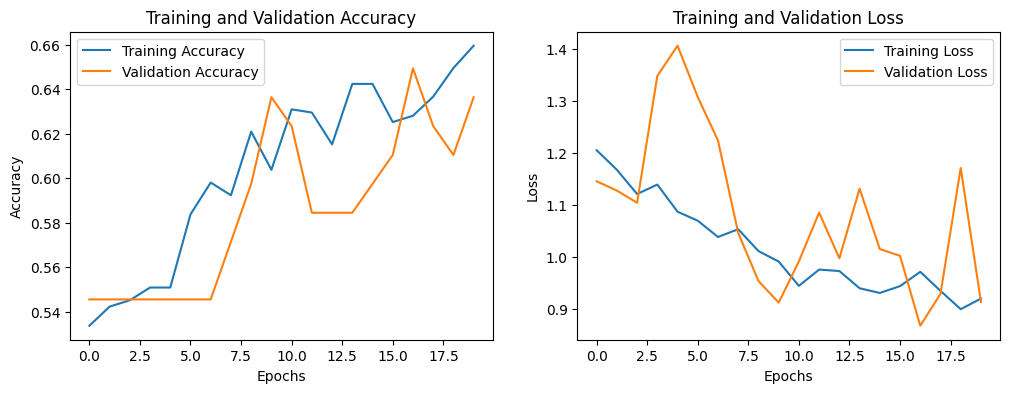

In [27]:
# PLOTTING FOR FURTHER EVALUATION 

# The values I want to look at are the acuracy on training and validation data
# I want to make sure that the two values are not too far apart and that they have a stable augmentation during training

# Set up figure for plotting with a size 12x4 inches
plt.figure(figsize=(12, 4))

# Create a subplot for accuracy
plt.subplot(1, 2, 1)

# Plot the training accuracy retreived from the model 
plt.plot(result.history['accuracy'], label='Training Accuracy')

# Plot the validation accuracy for comparison
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')

# Labelling for the accuracy graph
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)

# Plot the loss training retreived from the model 
plt.plot(result.history['loss'], label='Training Loss')

# Plot the validation loss for comparison.
plt.plot(result.history['val_loss'], label='Validation Loss')

# Labelling for the loss graph
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Execute it 
plt.show()

These graphs shows the training and validation accuracy and loss over a number of training epochs for a machine learning model. It helps in understanding how the model is learning and how well it understands to new unseen data. The two plots provide a clear and comparative view of the model's performance throughout the training process.

Training and Validation Accuracy:
The training accuracy is increasing over time, which means model is learning from the training data and improves its ability to predict the correct class labels (bicycles, cars, deer and mountains) over time. The validation accuracy is following the training accuracy to some extent but is overall lower and shows some fluctuations. This may mean the model might be fitting the training data well but struggling to achieve the same level of performance on unseen data, due to overfitting.

Training and Validation Loss:
The training loss is decreasing, which is expected as the model optimises its weights.
The validation loss, although decreasing overall, shows some spikes. The spikes in validation loss also suggest that the model's performance on the validation set is inconsistent.

Overfitting:
The discrepancy between the training and validation performance with training scores better than validation, may mean the model is overfitting. Essentially, the model is memorising rather than learning to generalise from the training set, which limits its predictivness on unseen data.

To improve:
To improve the model, I can increase the dropout rate or collecting more varied training data. Or use techniques like cross-validation to ensure that the validation metrics are reliable and to perform hyperparameter tuning like adjusting the learning rate, changing the optimiser to find the best settings for the model. Or Increase data augmentation, which helps the model generalise better. Or early stopping, to prevent the model from continuing to train once the validation loss stops improving, reducing overfitting.

In [32]:
# Save the model for question 3 (input question)
model.save("./model/")

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets
